In [10]:
# baseline_FCN.py의 GroupKFold 분할 결과를 메타데이터 기준으로 시각화
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from collections import Counter
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# ============================================================
# 0. Seed 설정 (baseline_FCN.py와 동일)
# ============================================================
RANDOM_SEED = 21

def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

set_seed()
print(f"Seed set to {RANDOM_SEED}")

# ============================================================
# 1. baseline_FCN.py와 동일한 방식으로 이미지/라벨 목록 준비
# ============================================================
IMAGE_ROOT = "/data/ephemeral/home/dataset/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/dataset/train/outputs_json"

# baseline_FCN.py와 동일한 방식으로 파일 찾기
pngs = sorted([
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
])

jsons = sorted([
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
])

# baseline_FCN.py와 동일한 검증
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}
assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

print(f"Total images: {len(pngs)}")
print(f"Total labels: {len(jsons)}")


Seed set to 21
Total images: 800
Total labels: 800


In [11]:
# ============================================================
# 2. baseline_FCN.py와 동일한 방식으로 GroupKFold 수행
# ============================================================
_filenames = np.array(pngs)
_labelnames = np.array(jsons)

# baseline_FCN.py와 동일한 groups 생성
groups = [os.path.dirname(fname) for fname in _filenames]

# dummy label (baseline_FCN.py와 동일)
ys = [0 for fname in _filenames]

# baseline_FCN.py와 동일한 GroupKFold 설정
# GroupKFold는 기본적으로 shuffle=False, random_state 없음
gkf = GroupKFold(n_splits=5)

# 각 fold별 train/val 인덱스 저장
fold_splits = {}
for i, (train_idx, val_idx) in enumerate(gkf.split(_filenames, ys, groups)):
    fold_splits[i] = {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'train_groups': np.array(groups)[train_idx],
        'val_groups': np.array(groups)[val_idx]
    }
    print(f"Fold {i}: train={len(train_idx)}, val={len(val_idx)}")
    print(f"  Train groups: {len(set(fold_splits[i]['train_groups']))}, Val groups: {len(set(fold_splits[i]['val_groups']))}")
    
    # 겹침 확인
    overlap = set(fold_splits[i]['train_groups']) & set(fold_splits[i]['val_groups'])
    print(f"  Overlap: {'None ✅' if len(overlap) == 0 else overlap}")
    print()


Fold 0: train=640, val=160
  Train groups: 320, Val groups: 80
  Overlap: None ✅

Fold 1: train=640, val=160
  Train groups: 320, Val groups: 80
  Overlap: None ✅

Fold 2: train=640, val=160
  Train groups: 320, Val groups: 80
  Overlap: None ✅

Fold 3: train=640, val=160
  Train groups: 320, Val groups: 80
  Overlap: None ✅

Fold 4: train=640, val=160
  Train groups: 320, Val groups: 80
  Overlap: None ✅



In [12]:
# ============================================================
# 3. 메타데이터 로드 및 정규화 (k-fold-maker.py와 동일)
# ============================================================
meta_df = pd.read_excel("/data/ephemeral/home/dataset/meta_data.xlsx")

meta_df['gender'] = (
    meta_df['성별']
    .astype(str)
    .str.replace('_x0008_', '', regex=False)
    .str.replace('x0008', '', regex=False)
    .str.strip()
    .map({'여': 'Female', '남': 'Male'})
)

meta_df = meta_df.rename(columns={
    '나이': 'age',
    '키(신장)': 'height',
    '체중(몸무게)': 'weight'
})

# Binning (k-fold-maker.py와 동일한 순서)
AGE_ORDER = ['<25', '25-30', '30-40', '40+']
HEIGHT_ORDER = ['<160', '160-168', '168-175', '175+']
WEIGHT_ORDER = ['<55', '55-63', '63-74', '74+']

meta_df['age_bin'] = pd.cut(
    meta_df['age'],
    bins=[0, 25, 30, 40, 200],
    labels=AGE_ORDER,
    right=True
).astype(CategoricalDtype(categories=AGE_ORDER, ordered=True))

meta_df['height_bin'] = pd.cut(
    meta_df['height'],
    bins=[0, 160, 168, 175, 300],
    labels=HEIGHT_ORDER,
    right=True
).astype(CategoricalDtype(categories=HEIGHT_ORDER, ordered=True))

meta_df['weight_bin'] = pd.cut(
    meta_df['weight'],
    bins=[0, 55, 63, 74, 300],
    labels=WEIGHT_ORDER,
    right=True
).astype(CategoricalDtype(categories=WEIGHT_ORDER, ordered=True))

meta_df['ID_str'] = meta_df['ID'].apply(lambda x: f"ID{int(x):03d}")

print("Overall gender distribution:")
print(meta_df['gender'].value_counts(dropna=False))
print("\nOverall age bin distribution:")
print(meta_df['age_bin'].value_counts(sort=False))
print("\nOverall height bin distribution:")
print(meta_df['height_bin'].value_counts(sort=False))
print("\nOverall weight bin distribution:")
print(meta_df['weight_bin'].value_counts(sort=False))


Overall gender distribution:
gender
Female    288
Male      262
Name: count, dtype: int64

Overall age bin distribution:
age_bin
<25      148
25-30    176
30-40    139
40+       87
Name: count, dtype: int64

Overall height bin distribution:
height_bin
<160       121
160-168    170
168-175    164
175+        95
Name: count, dtype: int64

Overall weight bin distribution:
weight_bin
<55      154
55-63    132
63-74    137
74+      127
Name: count, dtype: int64


In [13]:
# ============================================================
# 4. 각 fold별 validation 그룹 추출 (k-fold-maker.py 스타일)
# ============================================================
# k-fold-maker.py처럼 validation만 추출 (fold는 1부터 시작)
id2meta = meta_df.set_index('ID_str')

fold_val_ids = {
    fold + 1: list(set(fold_splits[fold]['val_groups']))
    for fold in range(5)
}

print("Validation IDs per fold:")
for fold, ids in fold_val_ids.items():
    print(f"  Fold {fold}: {len(ids)} IDs")


Validation IDs per fold:
  Fold 1: 80 IDs
  Fold 2: 80 IDs
  Fold 3: 80 IDs
  Fold 4: 80 IDs
  Fold 5: 80 IDs


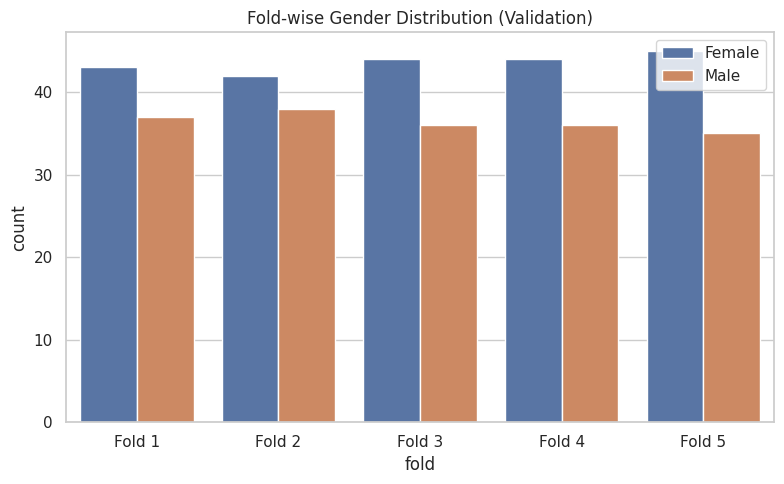

In [14]:
# ============================================================
# 5. Fold-wise Distribution Visualization (k-fold-maker.py와 동일)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# -----------------------------
# Gender
# -----------------------------
gender_dist = []
for fold, ids in fold_val_ids.items():
    for g, cnt in id2meta.loc[ids]['gender'].value_counts(sort=False).items():
        gender_dist.append({"fold": f"Fold {fold}", "gender": g, "count": cnt})

df = pd.DataFrame(gender_dist)
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="fold", y="count", hue="gender")
plt.title("Fold-wise Gender Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


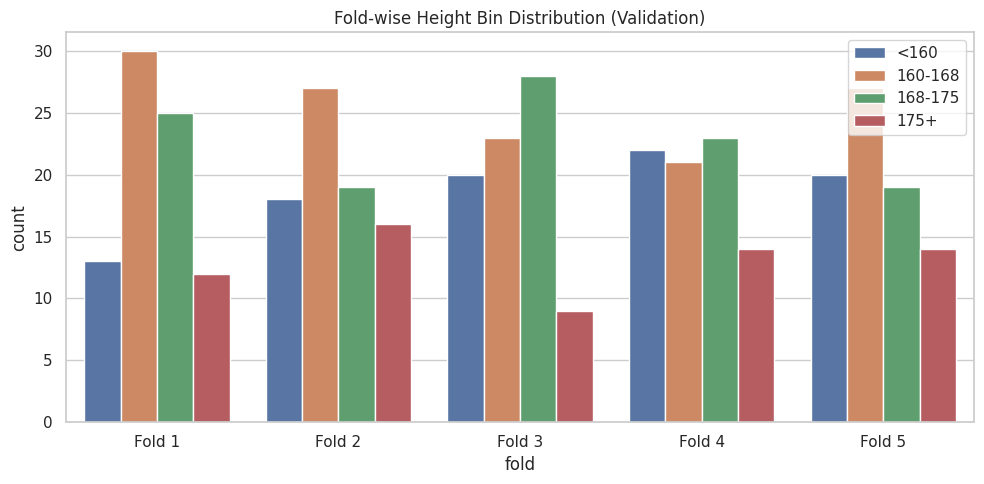

In [15]:
# -----------------------------
# Height bin
# -----------------------------
height_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['height_bin'].value_counts(sort=False).items():
        height_dist.append({"fold": f"Fold {fold}", "height_bin": b, "count": cnt})

df = pd.DataFrame(height_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="height_bin", hue_order=HEIGHT_ORDER
)
plt.title("Fold-wise Height Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


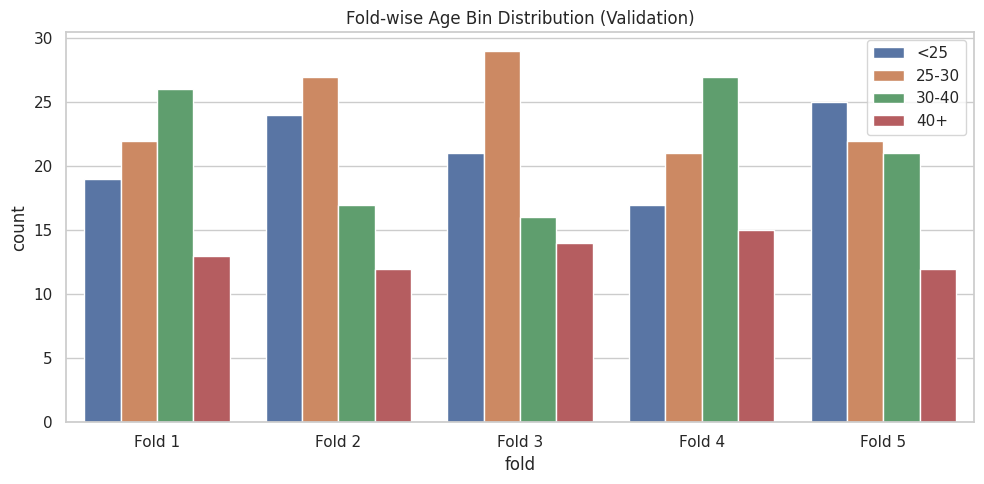

In [16]:
# -----------------------------
# Age bin
# -----------------------------
age_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['age_bin'].value_counts(sort=False).items():
        age_dist.append({"fold": f"Fold {fold}", "age_bin": b, "count": cnt})

df = pd.DataFrame(age_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="age_bin", hue_order=AGE_ORDER
)
plt.title("Fold-wise Age Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


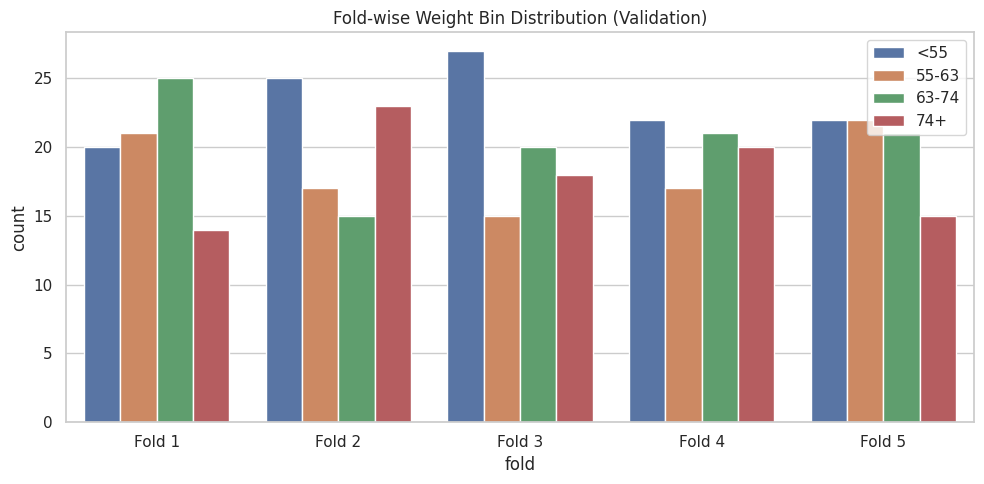

In [17]:
# -----------------------------
# Weight bin
# -----------------------------
weight_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['weight_bin'].value_counts(sort=False).items():
        weight_dist.append({"fold": f"Fold {fold}", "weight_bin": b, "count": cnt})

df = pd.DataFrame(weight_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="weight_bin", hue_order=WEIGHT_ORDER
)
plt.title("Fold-wise Weight Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


### Coarse Stratification: 성별 + 키 기준 분포 (Validation)


Coarse Stratification
coarse_stratify
Female_>162    139
Male_≤174      147
Female_≤162    149
Male_>174      115
Name: count, dtype: int64



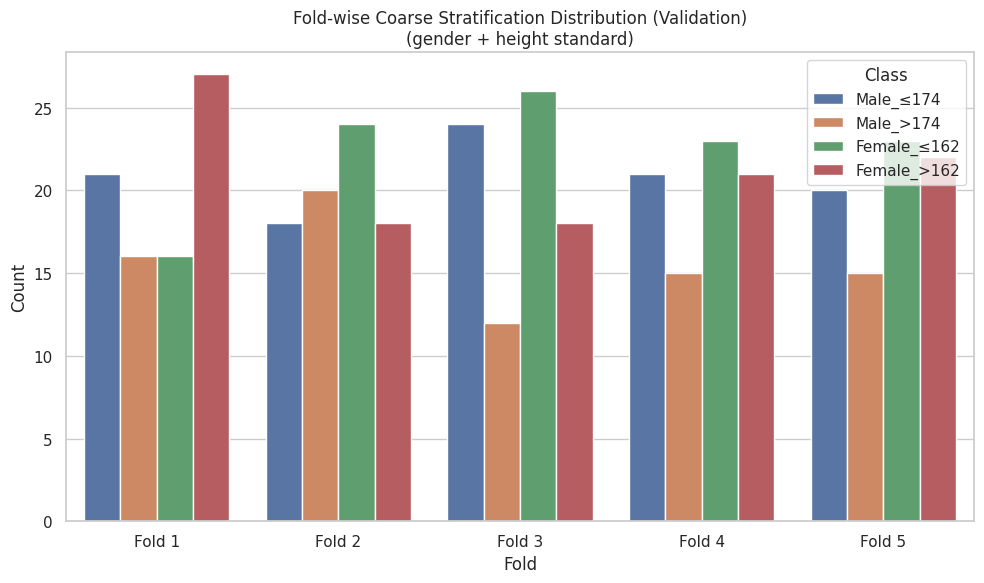

each fold's Coarse Stratification distribution

Fold 1:
  Male_≤174      :  21
  Male_>174      :  16
  Female_≤162    :  16
  Female_>162    :  27

Fold 2:
  Male_≤174      :  18
  Male_>174      :  20
  Female_≤162    :  24
  Female_>162    :  18

Fold 3:
  Male_≤174      :  24
  Male_>174      :  12
  Female_≤162    :  26
  Female_>162    :  18

Fold 4:
  Male_≤174      :  21
  Male_>174      :  15
  Female_≤162    :  23
  Female_>162    :  21

Fold 5:
  Male_≤174      :  20
  Male_>174      :  15
  Female_≤162    :  23
  Female_>162    :  22


In [20]:
# ============================================================
# Coarse Stratification: 성별 + 키 기준 4개 클래스
# ============================================================
# 남자 키 평균: 174
# 여자 키 평균: 162

# 4개 클래스 생성
def get_coarse_stratify_label(row):
    gender = row['gender']
    height = row['height']
    
    if gender == 'Male':
        if height <= 174:
            return 'Male_≤174'
        else:
            return 'Male_>174'
    else:  # Female
        if height <= 162:
            return 'Female_≤162'
        else:
            return 'Female_>162'

meta_df['coarse_stratify'] = meta_df.apply(get_coarse_stratify_label, axis=1)

# id2meta를 다시 생성 (coarse_stratify 컬럼이 포함되도록)
id2meta = meta_df.set_index('ID_str')

# 전체 분포 확인
print("=" * 60)
print("Coarse Stratification")
print("=" * 60)
print(meta_df['coarse_stratify'].value_counts(sort=False))
print()

# 각 validation fold별 분포 계산
coarse_dist = []
for fold, ids in fold_val_ids.items():
    fold_meta = id2meta.loc[ids]
    for label, cnt in fold_meta['coarse_stratify'].value_counts(sort=False).items():
        coarse_dist.append({
            "fold": f"Fold {fold}",
            "class": label,
            "count": cnt
        })

df_coarse = pd.DataFrame(coarse_dist)

# 클래스 순서 정의 (시각화용)
CLASS_ORDER = ['Male_≤174', 'Male_>174', 'Female_≤162', 'Female_>162']

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_coarse, 
    x="fold", 
    y="count", 
    hue="class",
    hue_order=CLASS_ORDER
)
plt.title("Fold-wise Coarse Stratification Distribution (Validation)\n(gender + height standard)")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.legend(loc="upper right", title="Class")
plt.tight_layout()
plt.show()

# 각 fold별 상세 통계 출력
print("=" * 60)
print("each fold's Coarse Stratification distribution")
print("=" * 60)
for fold, ids in fold_val_ids.items():
    fold_meta = id2meta.loc[ids]
    print(f"\nFold {fold}:")
    for label in CLASS_ORDER:
        cnt = (fold_meta['coarse_stratify'] == label).sum()
        print(f"  {label:15s}: {cnt:3d}")


### GroupKFold Distribution Uniformity Analysis


GroupKFold Results: Class-wise Fold Distribution Statistics

Male_≤174:
  Mean: 20.80
  Std: 1.94
  Min: 18, Max: 24
  CV (Coefficient of Variation): 9.32%
  Fold Distribution: [21 18 24 21 20]

Male_>174:
  Mean: 15.60
  Std: 2.58
  Min: 12, Max: 20
  CV (Coefficient of Variation): 16.52%
  Fold Distribution: [16 20 12 15 15]

Female_≤162:
  Mean: 22.40
  Std: 3.38
  Min: 16, Max: 26
  CV (Coefficient of Variation): 15.10%
  Fold Distribution: [16 24 26 23 23]

Female_>162:
  Mean: 21.20
  Std: 3.31
  Min: 18, Max: 27
  CV (Coefficient of Variation): 15.62%
  Fold Distribution: [27 18 18 21 22]

Overall Average CV: 14.14%
(Lower CV means more uniform distribution across folds)



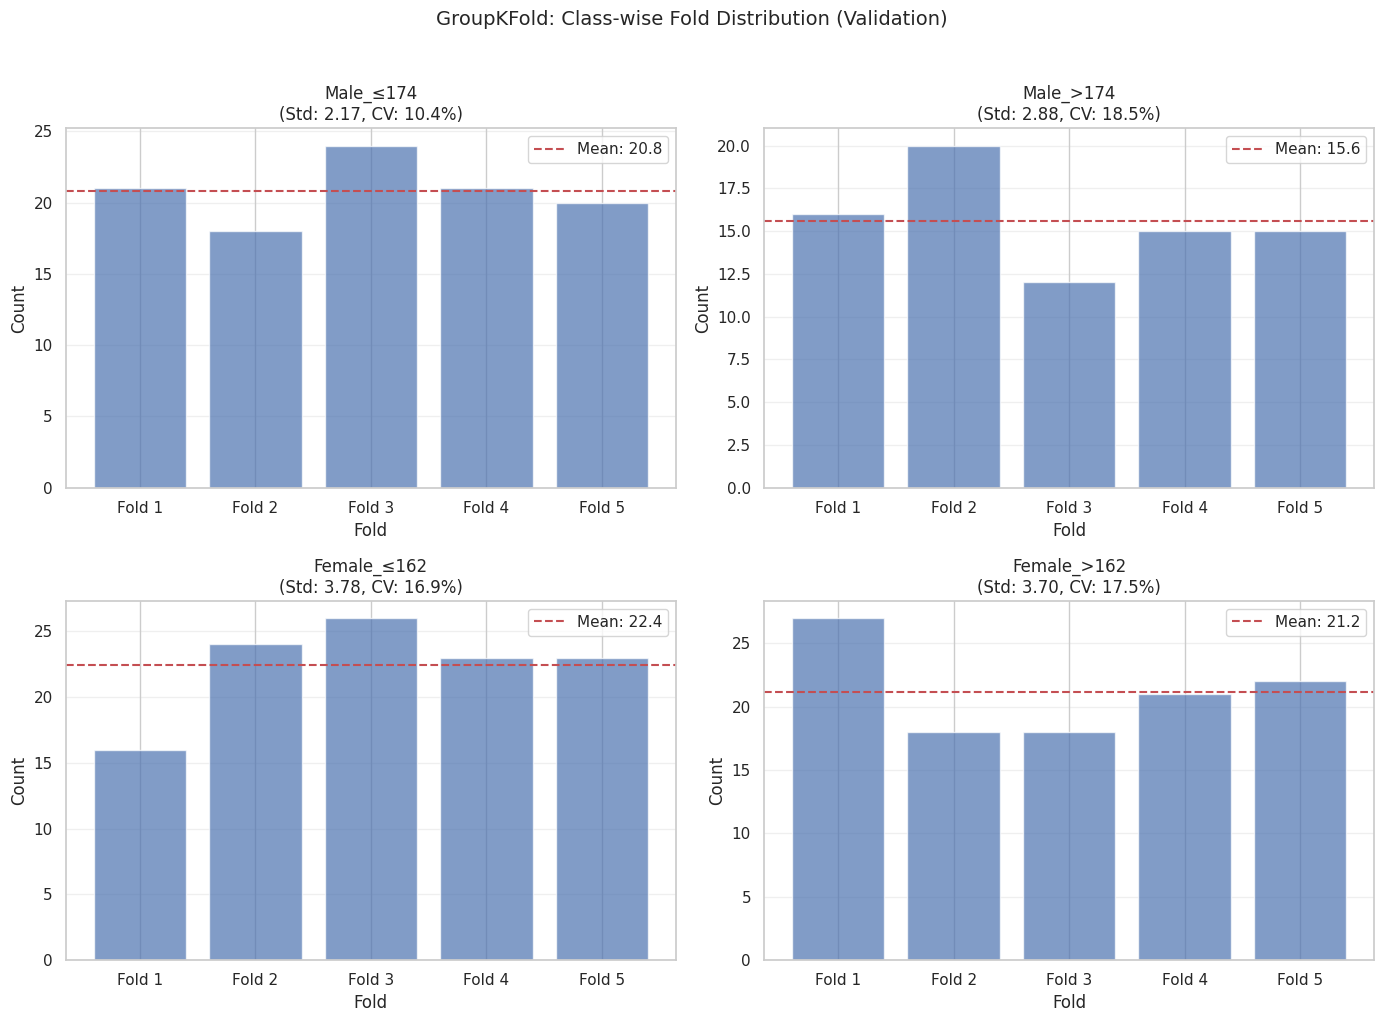

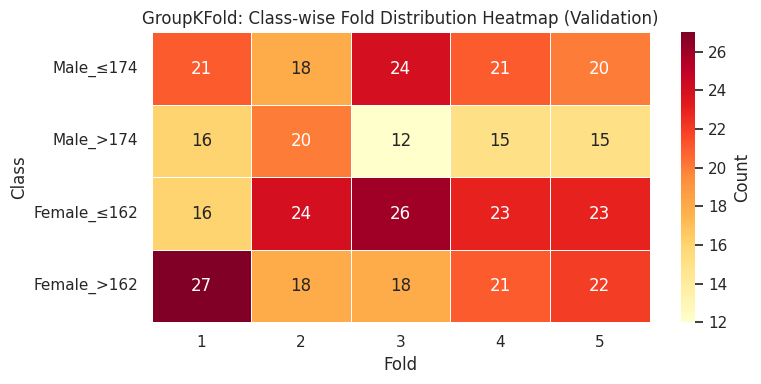

In [22]:
# ============================================================
# GroupKFold Distribution Uniformity Analysis
# ============================================================
# Check how uniform the distribution is across folds for each class

# Organize class distribution per fold into a DataFrame
fold_class_dist = []
for fold, ids in fold_val_ids.items():
    fold_meta = id2meta.loc[ids]
    for label in CLASS_ORDER:
        cnt = (fold_meta['coarse_stratify'] == label).sum()
        fold_class_dist.append({
            "fold": fold,
            "class": label,
            "count": cnt
        })

df_fold_class = pd.DataFrame(fold_class_dist)

# Calculate statistics across folds for each class
print("=" * 60)
print("GroupKFold Results: Class-wise Fold Distribution Statistics")
print("=" * 60)
print()

class_stats = []
for label in CLASS_ORDER:
    class_counts = df_fold_class[df_fold_class['class'] == label]['count'].values
    mean_count = class_counts.mean()
    std_count = class_counts.std()
    min_count = class_counts.min()
    max_count = class_counts.max()
    cv = (std_count / mean_count) * 100 if mean_count > 0 else 0  # Coefficient of Variation
    
    class_stats.append({
        'class': label,
        'mean': mean_count,
        'std': std_count,
        'min': min_count,
        'max': max_count,
        'cv': cv
    })
    
    print(f"{label}:")
    print(f"  Mean: {mean_count:.2f}")
    print(f"  Std: {std_count:.2f}")
    print(f"  Min: {min_count:.0f}, Max: {max_count:.0f}")
    print(f"  CV (Coefficient of Variation): {cv:.2f}%")
    print(f"  Fold Distribution: {class_counts}")
    print()

df_stats = pd.DataFrame(class_stats)

# Overall average coefficient of variation
overall_cv = df_stats['cv'].mean()
print(f"Overall Average CV: {overall_cv:.2f}%")
print("(Lower CV means more uniform distribution across folds)")
print()

# Visualization: Compare distribution across folds for each class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, label in enumerate(CLASS_ORDER):
    class_data = df_fold_class[df_fold_class['class'] == label]
    ax = axes[idx]
    
    bars = ax.bar(range(1, 6), class_data['count'], alpha=0.7)
    ax.axhline(y=class_data['count'].mean(), color='r', linestyle='--', 
               label=f'Mean: {class_data["count"].mean():.1f}')
    ax.set_title(f'{label}\n(Std: {class_data["count"].std():.2f}, CV: {class_data["count"].std()/class_data["count"].mean()*100:.1f}%)')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Count')
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels([f'Fold {i}' for i in range(1, 6)])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('GroupKFold: Class-wise Fold Distribution (Validation)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Visualization with heatmap
pivot_df = df_fold_class.pivot(index='class', columns='fold', values='count')
pivot_df = pivot_df.reindex(CLASS_ORDER)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('GroupKFold: Class-wise Fold Distribution Heatmap (Validation)')
plt.xlabel('Fold')
plt.ylabel('Class')
plt.tight_layout()
plt.show()
